# 1. Set the Environment

We start by importing the python packages needed to set the environment:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats as scs
from scipy.stats.kde import gaussian_kde
import pandas_datareader.data as web
%matplotlib inline

We also create the function "print_statistics", which is a wrapper function for the describe function from the scipy.stats sublibrary. It mainly generates a more (human-)readable output for such statistics as the mean, the skewness or the kurtosis of our data sets:

In [2]:
def print_statistics(array):
    ''' Prints selected statistics.
    
    Parameters
    ==========
    array: ndarray
        object to generate statistics on
    '''
    sta = scs.describe(array)
    print("%14s %15s" % ('statistic', 'value'))
    print(30 * "-")
    print("%14s %15.5f" % ('size', sta[0]))
    print("%14s %15.5f" % ('min', array.min()))
    print("%14s %15.5f" % ('max', array.max()))
    print("%14s %15.5f" % ('mean', array.mean()))
    print("%14s %15.5f" % ('median', array.median()))
    print("%14s %15.5f" % ('std', np.std(array)))

# 2. Generate the Data Set

Once the environment is set up, we generate the data set by importing the [S&P 500 (^GSPC)](https://uk.finance.yahoo.com/q?s=%5EGSPC) index from Yahoo! Finance using the [pandas-datareader](https://pandas-datareader.readthedocs.org/en/latest/index.html) package.

In [3]:
Instrument = '^GSPC'
start_date = '1/1/2000'
end_date = '3/1/2016'
df = web.DataReader(Instrument, data_source = 'yahoo',
                      start = start_date, end = end_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4065 entries, 2000-01-03 to 2016-03-01
Data columns (total 6 columns):
Open         4065 non-null float64
High         4065 non-null float64
Low          4065 non-null float64
Close        4065 non-null float64
Volume       4065 non-null int64
Adj Close    4065 non-null float64
dtypes: float64(5), int64(1)
memory usage: 222.3 KB


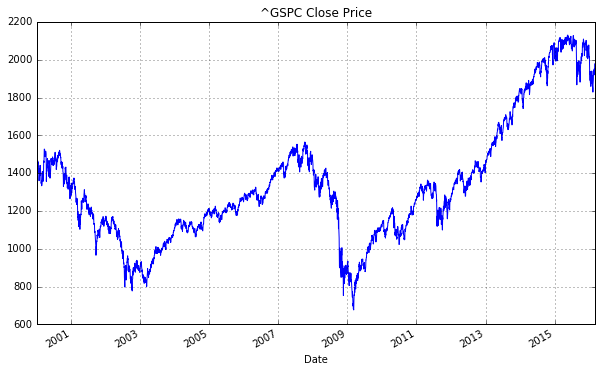

In [4]:
df['Close'].plot(grid = True, figsize = (10, 6))
plt.title('%s Close Price' % Instrument)

# 3. Analyse data

We start by setting the first two parameters for the trend strategy, which are the short-term and long-term moving averages. 
The Moving Average (MA) is one of the most popular and often-used technical indicator. It is easy to calculate and, once plotted on a chart, is a powerful visual trend-spotting tool. You will often hear about three types of moving average: simple, exponential and linear.

In [5]:
ma1 = 50    # Short-term moving average
ma2 = 150   # Long-term moving average

# Add two columns to the dataset with the calculated moving averages
df['ma1_%sd' % ma1] = np.round(pd.rolling_mean(df['Close'], 
                                        window = ma1), 2)
df['ma2_%sd' % ma2]  = np.round(pd.rolling_mean(df['Close'], 
                                        window = ma2), 2)

df.head() # Print the head of the dataset

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=50).mean()
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=150).mean()


,Open,High,Low,Close,Volume,Adj Close,ma1_50d,ma2_150d
Date,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,1455.219971,NaN,NaN
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,1399.420044,NaN,NaN
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,1402.109985,NaN,NaN
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,1403.449951,NaN,NaN
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,1441.469971,NaN,NaN


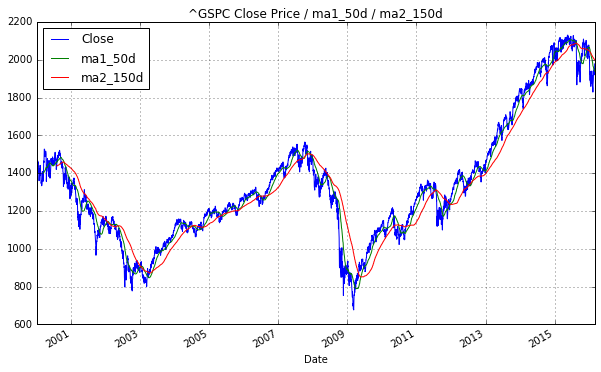

In [6]:
df[['Close', 'ma1_%sd' % ma1, 'ma2_%sd' % ma2]].plot(grid = True, figsize = (10, 6))
plt.title('%s Close Price / ma1_%sd / ma2_%sd' % (Instrument,ma1,ma2))

In [7]:
# Add a new column for the differences between the two trends
df['ma1_%sd - ma2_%sd' % (ma1, ma2)] = df['ma1_%sd' % ma1] - df['ma2_%sd' % ma2]

# Print statistics of the differences
print(Instrument)
print_statistics(df['ma1_%sd - ma2_%sd' % (ma1, ma2)])

^GSPC
     statistic           value
------------------------------
          size      4065.00000
           min      -253.20000
           max       103.52000
          mean         7.29777
        median        19.91500
           std        59.60617


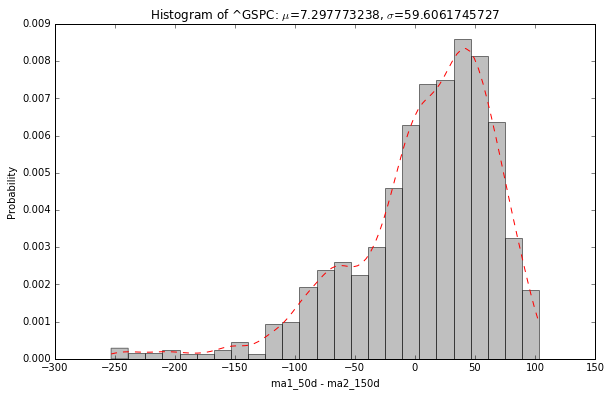

In [8]:
# example data
df_prob = df['ma1_%sd - ma2_%sd' % (ma1, ma2)].dropna() # Drop the NaN values for plotting

mu = df_prob.mean() # mean of distribution
sigma = np.std(df_prob) # standard deviation of distribution

num_bins = 25
# the histogram of the data
f = plt.subplots(1, 1, figsize = (10, 6))
n, bins, patches = plt.hist(df_prob, num_bins, normed=1, facecolor='gray', alpha=0.5)


"""
Add a 'best fit' line using the scipy.stats.kde
This creates the Kernel density estimation, 
a way to estimate the probability density function (PDF)
of a random variable in a non-parametric way.
"""

kde = gaussian_kde(df_prob)
# These are the values over wich the kernel will be evaluated
dist_space = np.linspace(df_prob.min(), df_prob.max(), 100)
# plot the results
plt.plot(dist_space, kde(dist_space), 'r--')


plt.xlabel('ma1_%sd - ma2_%sd' % (ma1, ma2))
plt.ylabel('Probability')
plt.title(r'Histogram of %s: $\mu$=%s, $\sigma$=%s' % (Instrument, mu, sigma))

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

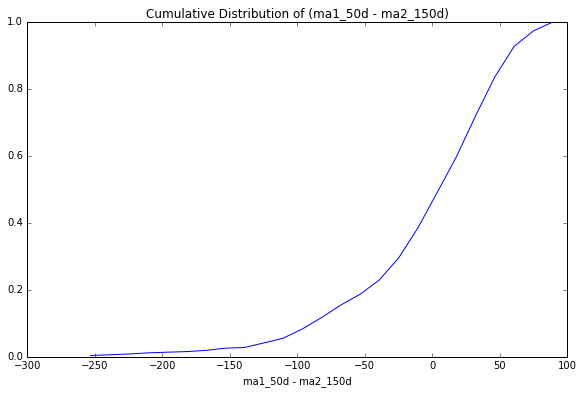

In [9]:
# example data
num_bins = 25
# the histogram of the data
f = plt.subplots(1, 1, figsize = (10, 6))
values, base = np.histogram(df_prob, num_bins)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative/max(cumulative), c='blue')
plt.xlabel('ma1_%sd - ma2_%sd' % (ma1, ma2))
plt.title(r'Cumulative Distribution of (ma1_%sd - ma2_%sd)' % (ma1, ma2))

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

# 4. Create the Trading System

Our basic data set is mainly complete, such that we now can devise a rule to generate trade signals. The rule says the following:
1. Buy signal (go long): the short-term Moving Average (MA1) trend is for the first
   time SD points above the long-term Moving Average (MA2) trend.
2. Wait (park in cash): the MA1 trend is within a range of
   +/- SD points around the MA2 trend.
3. Sell signal (go short): the MA1 trend is for the first
   time SD points below the MA2 trend.

In [10]:
SD = df_prob.median() # Value for the signal threshold.

"""
To make it more formal, we again generate a new column 
for what we call a regime.
"""

df['Regime'] = np.where(df['ma1_%sd - ma2_%sd' % (ma1, ma2)] > SD, 1, 0)
df['Regime'] = np.where(df['ma1_%sd - ma2_%sd' % (ma1, ma2)] < -SD, -1, 
                           df['Regime'])
df['Regime'].value_counts()

 1    1958
 0    1137
-1     970
Name: Regime, dtype: int64

If the short-term trend crosses the line of the long-term
trend it tends to rest there for a (longer) while. 
This is what we call regime:

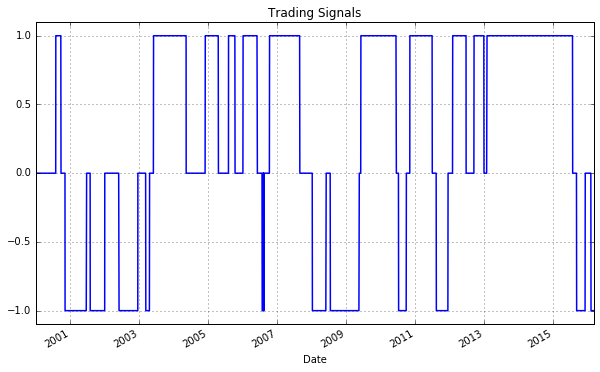

In [11]:
df['Regime'].plot(lw = 1.5, grid = True, figsize = (10, 6))
plt.ylim([-1.1, 1.1])
plt.title('Trading Signals')

The main assumptions for the trading strategy are:
 1. Cash does not bear any interest.
 2. No transaction costs. This seems justifiable since we
    do not plan to trade "too often".

The strategy pays off well; the investor is able to lock in
a much higher return over the relevant period than a plain
long investment would provide. The following figure compares
the cumulative, continuous returns of the index with the
cumulative, continuous returns of our strategy:

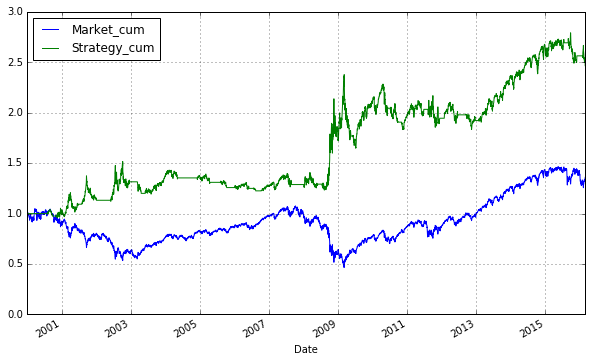

In [12]:
# We calculate the market returns
df['Market'] = np.log(df['Close'] / 
                         df['Close'].shift(1))

"""To get the returns of the trend-based trading strategy
we just have to multiply our Regime column, shifted by
one day, by the Returns column (the position is built
"yesterday" and yields "today's" returns):"""

df['Strategy'] = df['Regime'].shift(1) * df['Market']


df[['Market_cum', 'Strategy_cum']] = df[['Market', 'Strategy']].cumsum().apply(np.exp)
df[['Market_cum', 'Strategy_cum']].plot(grid = True,
                                         figsize = (10, 6))

# 5. Compute Delta-Normal Value-at-Risk

The Delta-Normal methodology is an analytical approach that assumes that the risk factors are lognormally distributed (i.e., log returns are normally distributed) and that the asset returns are linear in the risk factors.
In our basic example, we only have one asset and therefore we only need to compute the 1-year rolling variance of the SP500 log returns.

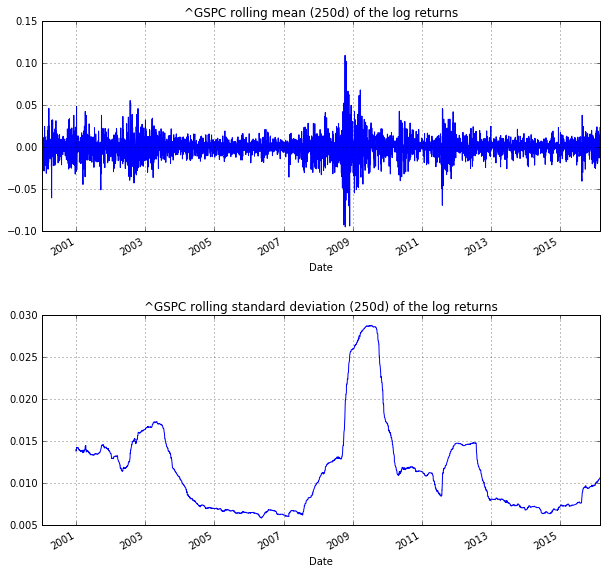

In [16]:
# Long-term window for the standard deviation
std = 250

# Add two columns to the dataset with the calculated 
# daily standard deviations for the market log returns
df['std_%sd' % std] = df['Market'].rolling(center=False,window=std).std()

plt.subplot(211)
df['Market'].plot(grid = True, figsize = (10, 10))
plt.title('%s rolling mean (%sd) of the log returns' % (Instrument,std))
plt.subplots_adjust(hspace = 0.4)

plt.subplot(212)
df['std_%sd' % std].plot(grid = True, figsize = (10, 10))
plt.title('%s rolling standard deviation (%sd) of the log returns' % (Instrument,std))

The chart below shows the 1-day VaR measure at different confidence levels.

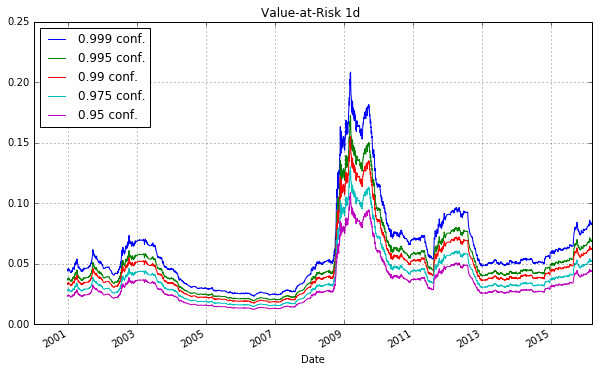

In [14]:
conf_level = [0.999, 0.995, 0.99, 0.975, 0.95] # Confidence levels
time_horiz = 1 # Time horizon in days

for i, item in enumerate(conf_level):
    (df['Strategy_cum'] * (np.exp(df['std_%sd' % std] * 
                            scs.norm.ppf(conf_level[i]) * 
                                np.sqrt(time_horiz)) - 1)).plot(grid = True,
                                    figsize = (10, 6), label = '%s conf.' % conf_level[i])
plt.legend(loc=2)
plt.title('Value-at-Risk %sd ' % (time_horiz))

The chart below shows the 95% VaR measure at different time horizons.

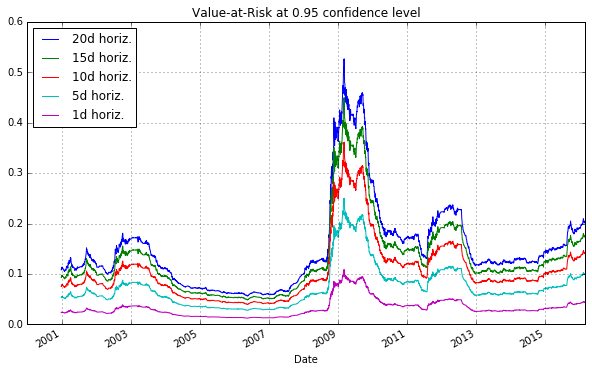

In [15]:
conf_level = .95 # Confidence level
time_horiz = [20, 15, 10, 5, 1] # Time horizon in days

for i, item in enumerate(time_horiz):
    (df['Strategy_cum'] * (np.exp(df['std_%sd' % std] * 
                                  scs.norm.ppf(conf_level) * 
                                  np.sqrt(time_horiz[i])) - 1)).plot(grid = True,
                                             figsize = (10, 6), label = '%sd horiz.' % time_horiz[i])
plt.legend(loc=2)
plt.title('Value-at-Risk at %s confidence level' % (conf_level))

# Summary

We have introduced some coding for creating a basic Trade System using data from [Yahoo! Finance](https://uk.finance.yahoo.com) and the following variables / assumptions:
1. Instrument = '^GSPC' (Index S&P 500)
2. Start date = January 1, 2000
3. End date = March 1, 2016
4. Short-term moving average calculated over 50 days (MA1)
5. Long-term moving average calculated over 150 days (MA2)
6. Signal threshold (SD) as the median of the distribution
   of the differences between moving averages.
7. Cash does not bear any interest.
8. No transaction costs.

**Practice Questions & Excercises**
1. What is the value of the Signal Threshold (SD) that maximises the total
   market return at the end date, all the rest being equal?
2. What are the periods in days of the two moving averages that maximise 
   the total market return at the end date? 